In [1]:
!pip install python-chess==1.2.0

     |████████████████████████████████| 140 kB 4.1 MB/s 
  Attempting uninstall: python-chess
    Found existing installation: python-chess 0.23.11
    Uninstalling python-chess-0.23.11:
      Successfully uninstalled python-chess-0.23.11


In [2]:
!wget https://stockfishchess.org/files/stockfish_14.1_linux_x64.zip
!unzip -o stockfish_14.1_linux_x64.zip
!chmod +x stockfish_14.1_linux_x64/stockfish_14.1_linux_x64

--2021-11-12 16:43:23--  https://stockfishchess.org/files/stockfish_14.1_linux_x64.zip
Resolving stockfishchess.org (stockfishchess.org)... 104.25.159.9, 104.25.158.9, 172.67.80.249, ...
Connecting to stockfishchess.org (stockfishchess.org)|104.25.159.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28788691 (27M) [application/zip]
Saving to: ‘stockfish_14.1_linux_x64.zip’

stockfish_14.1_linu 100%[===================>]  27.45M  80.4MB/s    in 0.3s    

2021-11-12 16:43:24 (80.4 MB/s) - ‘stockfish_14.1_linux_x64.zip’ saved [28788691/28788691]

Archive:  stockfish_14.1_linux_x64.zip
  inflating: stockfish_14.1_linux_x64/AUTHORS  
  inflating: stockfish_14.1_linux_x64/Copying.txt  
  inflating: stockfish_14.1_linux_x64/info.txt  
  inflating: stockfish_14.1_linux_x64/stockfish_14.1_linux_x64  
   creating: stockfish_14.1_linux_x64/stockfish_14.1_src/
   creating: stockfish_14.1_linux_x64/stockfish_14.1_src/.github/
   creating: stockfish_14.1_linux_x64/stockfis

In [17]:
import chess
import chess.pgn
import chess.engine

import math
import random
import time
from IPython.display import display

In [4]:
from chess import engine

In [5]:
class node():
  def __init__(self):
    self.state = chess.Board()
    self.action = ''
    self.children = set()
    self.parent = None
    self.N = 0
    self.n = 0
    self.v = 0

In [6]:
# upper confidence bound
def ucb1(current_node):
  return current_node.v + 2 * (math.sqrt(math.log(current_node.N + math.e + (10**-6)) / (current_node.n + (10**-10))))

def expand(current_node, is_white):
  if len(current_node.children) == 0:
    return current_node
  
  if is_white:
    idx = -1
    max_ucb = -math.inf
    sel_child = None
    for child in current_node.children:
      tmp = ucb1(child)
      if tmp > max_ucb:
        idx = child
        max_ucb = tmp
        sel_child = child
    return expand(sel_child, is_white)
  else:
    min_ucb = math.inf
    sel_child = None
    for child in current_node.children:
      tmp = ucb1(child)
      if tmp < min_ucb:
        idx = child
        min_ucb = tmp
        sel_child = child
    return expand(sel_child, is_white)

def rollout(current_node):
  if current_node.state.is_game_over():
    board = current_node.state
    if board.result() == '1-0':
      return 1, current_node
    elif board.result() == '0-1':
      return -1, current_node
    else:
      return 0.5, current_node
  
  all_moves = [current_node.state.san(i) for i in list(current_node.state.legal_moves)]

  for move in all_moves:
    tmp_state = chess.Board(current_node.state.fen())
    tmp_state.push_san(move)
    child = node()
    child.state = tmp_state
    child.parent = current_node
    current_node.children.add(child)
  
  random_state = random.choice(list(current_node.children))

  return rollout(random_state)

def rollback(current_node, reward):
  current_node.n += 1
  current_node.v += reward
  while(current_node.parent != None):
    current_node.N += 1
    current_node = current_node.parent
  return current_node

def monte_carlo_tree_search_prediction(current_node, is_over, is_white, iterations=10):
  if(is_over):
    return -1
  
  all_moves = [current_node.state.san(i) for i in list(current_node.state.legal_moves)]
  map_state_move = dict()

  for move in all_moves:
    tmp_state = chess.Board(current_node.state.fen())
    tmp_state.push_san(move)
    child = node()
    child.state = tmp_state
    child.parent = current_node
    current_node.children.add(child)
    map_state_move[child] = move

  while(iterations > 0):
    if is_white:
      idx = -1
      max_ucb = -math.inf
      sel_child = None
      for child in current_node.children:
        tmp = ucb1(child)
        if tmp > max_ucb:
          idx = child
          max_ucb = tmp
          sel_child = child
      ex_child = expand(sel_child, 0)
      reward, state = rollout(ex_child)
      current_node = rollback(state, reward)
      iterations -= 1
    else:
      idx = -1
      min_ucb = math.inf
      sel_child = None
      for child in current_node.children:
        tmp = ucb1(child)
        if tmp < min_ucb:
          idx = child
          min_ucb = tmp
          sel_child = child
      ex_child = expand(sel_child, 1)
      reward, state = rollout(ex_child)
      current_node = rollback(state, reward)
      iterations -= 1

  if is_white:
    max_ucb = -math.inf
    idx = -1
    selected_move = ''
    for child in current_node.children:
      tmp = ucb1(child)
      if tmp > max_ucb:
        max_ucb = tmp
        selected_move = map_state_move[child]
  else:
    min_ucb = math.inf
    idx = -1
    selected_move = ''
    for child in current_node.children:
      tmp = ucb1(child)
      if tmp < min_ucb:
        min_ucb = tmp
        selected_move = map_state_move[child]
  
  return selected_move

White AI Action: e3, Monte Carlo Tree Search Duration: 23.63s
Black AI Action: Nc6, Monte Carlo Tree Search Duration: 22.54s
========== Turn 1 ==========


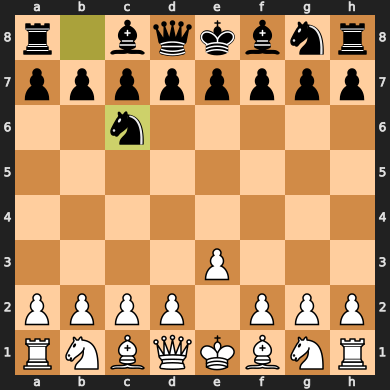


White AI Action: f3, Monte Carlo Tree Search Duration: 21.11s
Black AI Action: h6, Monte Carlo Tree Search Duration: 26.53s
========== Turn 2 ==========


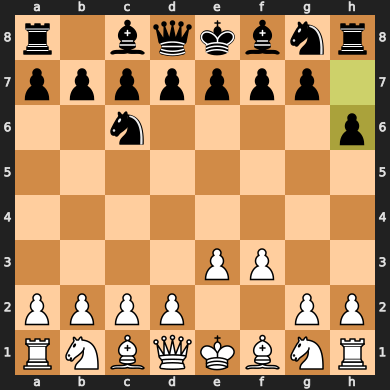


White AI Action: a3, Monte Carlo Tree Search Duration: 26.17s
Black AI Action: Ne5, Monte Carlo Tree Search Duration: 21.43s
========== Turn 3 ==========


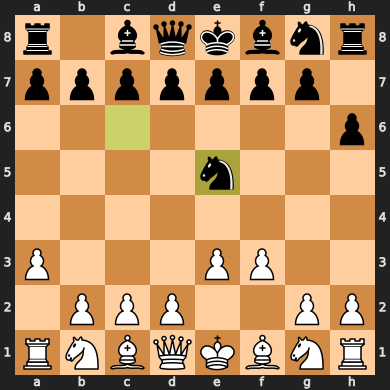


White AI Action: Nh3, Monte Carlo Tree Search Duration: 20.16s
Black AI Action: Nf6, Monte Carlo Tree Search Duration: 17.48s
========== Turn 4 ==========


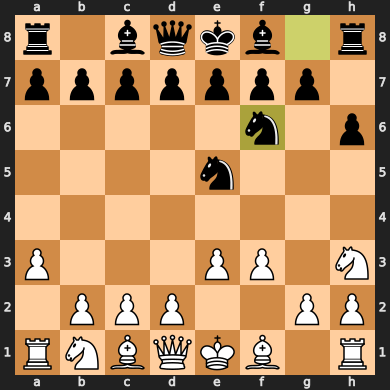


White AI Action: e4, Monte Carlo Tree Search Duration: 21.46s
Black AI Action: Nxf3+, Monte Carlo Tree Search Duration: 21.10s
========== Turn 5 ==========


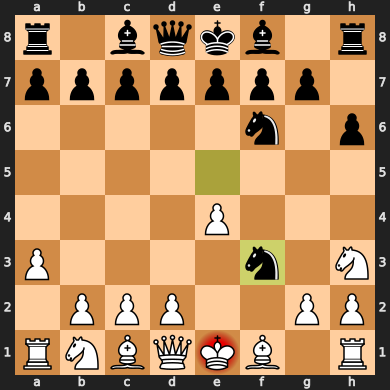


White AI Action: Qxf3, Monte Carlo Tree Search Duration: 22.89s
Black AI Action: d5, Monte Carlo Tree Search Duration: 20.61s
========== Turn 6 ==========


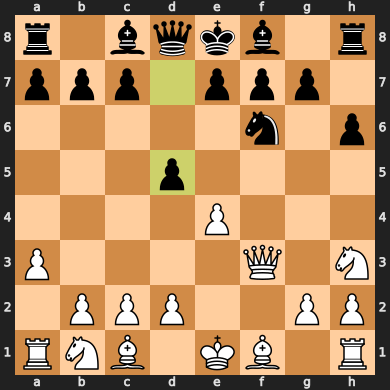


White AI Action: Qf2, Monte Carlo Tree Search Duration: 19.20s
Black AI Action: e5, Monte Carlo Tree Search Duration: 23.29s
========== Turn 7 ==========


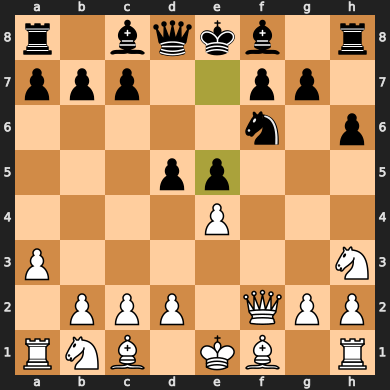


White AI Action: Qg1, Monte Carlo Tree Search Duration: 21.90s
Black AI Action: Kd7, Monte Carlo Tree Search Duration: 18.38s
========== Turn 8 ==========


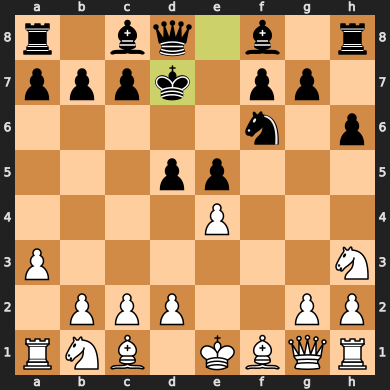


White AI Action: Ba6, Monte Carlo Tree Search Duration: 21.19s
Black AI Action: Ke8, Monte Carlo Tree Search Duration: 20.54s
========== Turn 9 ==========


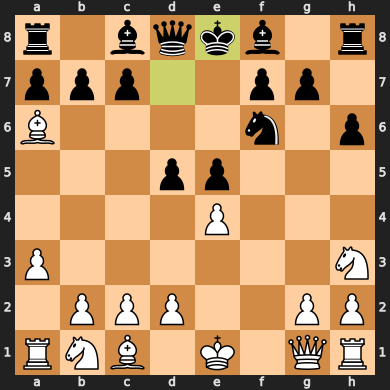


White AI Action: Bf1, Monte Carlo Tree Search Duration: 21.42s
Black AI Action: Qd6, Monte Carlo Tree Search Duration: 20.14s
========== Turn 10 ==========


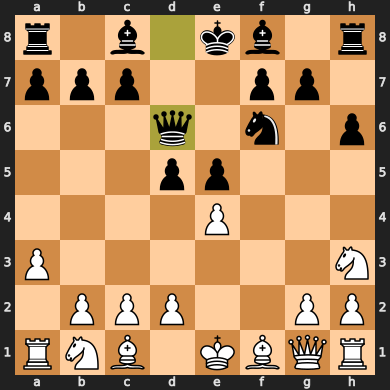


White AI Action: Bd3, Monte Carlo Tree Search Duration: 20.32s
Black AI Action: a5, Monte Carlo Tree Search Duration: 22.82s
========== Turn 11 ==========


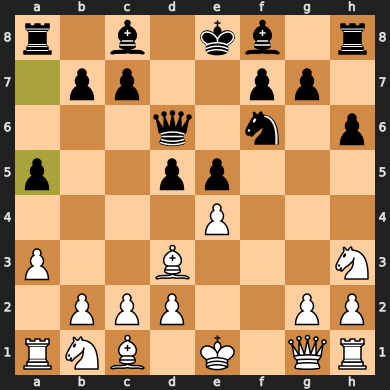


White AI Action: Qd4, Monte Carlo Tree Search Duration: 20.25s
Black AI Action: Qxa3, Monte Carlo Tree Search Duration: 19.74s
========== Turn 12 ==========


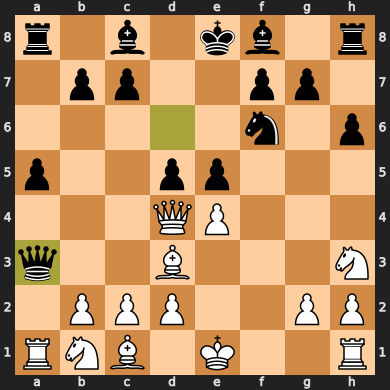


White AI Action: Qb4, Monte Carlo Tree Search Duration: 22.39s
Black AI Action: Be7, Monte Carlo Tree Search Duration: 19.43s
========== Turn 13 ==========


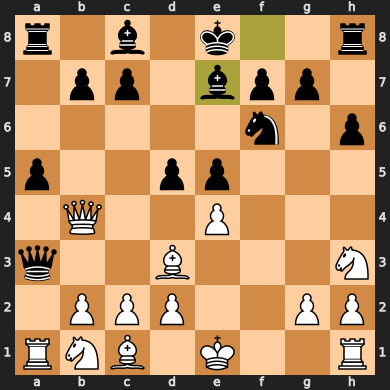


White AI Action: Qd4, Monte Carlo Tree Search Duration: 18.97s
Black AI Action: g6, Monte Carlo Tree Search Duration: 18.21s
========== Turn 14 ==========


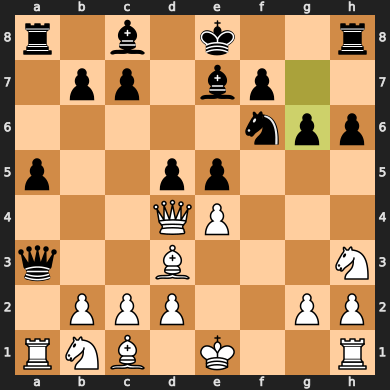


White AI Action: Qc4, Monte Carlo Tree Search Duration: 21.81s
Black AI Action: Qa4, Monte Carlo Tree Search Duration: 21.09s
========== Turn 15 ==========


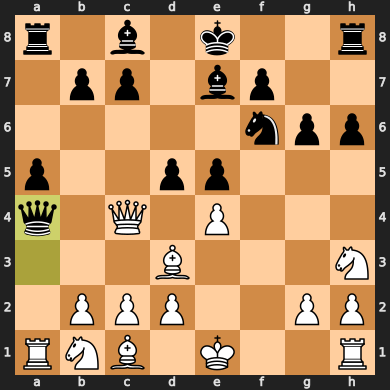


White AI Action: Qxc7, Monte Carlo Tree Search Duration: 19.62s
Black AI Action: Bxh3, Monte Carlo Tree Search Duration: 18.86s
========== Turn 16 ==========


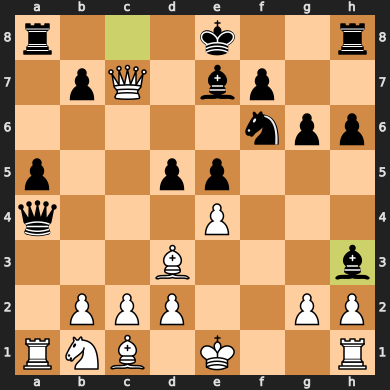


White AI Action: Qd8+, Monte Carlo Tree Search Duration: 18.21s
Black AI Action: Kxd8, Monte Carlo Tree Search Duration: 6.87s
========== Turn 17 ==========


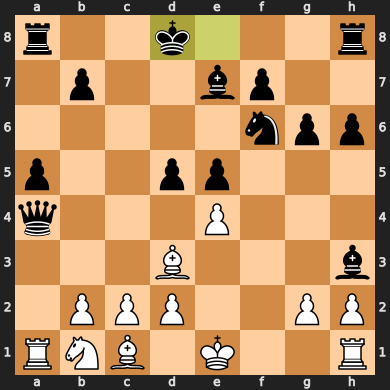


White AI Action: Rg1, Monte Carlo Tree Search Duration: 17.03s
Black AI Action: Bg4, Monte Carlo Tree Search Duration: 17.35s
========== Turn 18 ==========


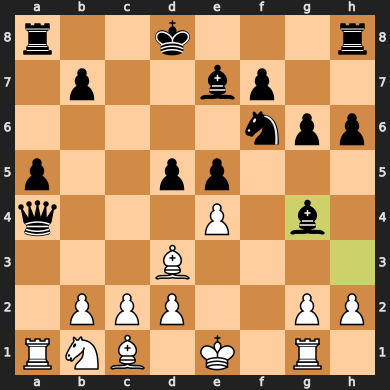


White AI Action: Bc4, Monte Carlo Tree Search Duration: 17.96s
Black AI Action: Kc7, Monte Carlo Tree Search Duration: 19.72s
========== Turn 19 ==========


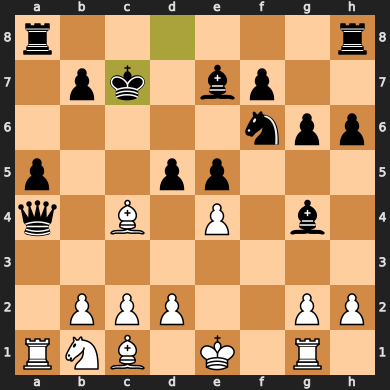


White AI Action: g3, Monte Carlo Tree Search Duration: 18.11s
Black AI Action: Qxc2, Monte Carlo Tree Search Duration: 18.69s
========== Turn 20 ==========


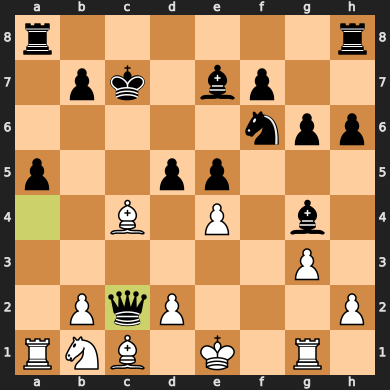


White AI Action: b4, Monte Carlo Tree Search Duration: 16.20s
Black AI Action: Kd6, Monte Carlo Tree Search Duration: 18.26s
========== Turn 21 ==========


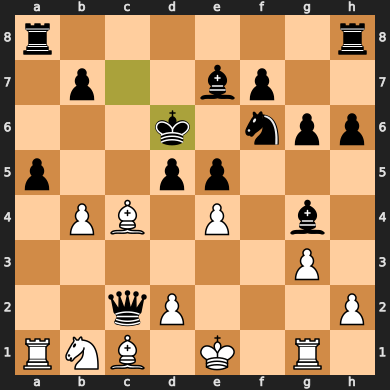


White AI Action: Kf1, Monte Carlo Tree Search Duration: 19.11s
Black AI Action: b5, Monte Carlo Tree Search Duration: 16.62s
========== Turn 22 ==========


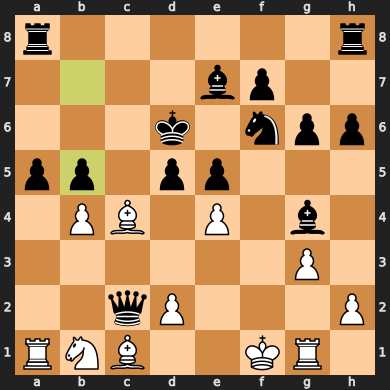


White AI Action: Bxd5, Monte Carlo Tree Search Duration: 15.84s
Black AI Action: Ne8, Monte Carlo Tree Search Duration: 19.09s
========== Turn 23 ==========


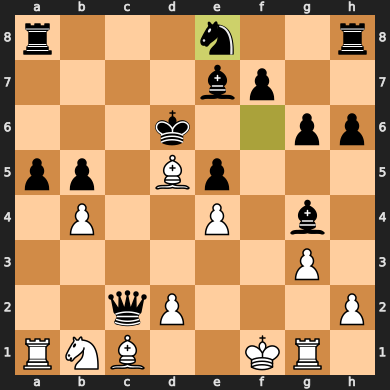


White AI Action: Ba2, Monte Carlo Tree Search Duration: 19.72s
Black AI Action: Qc3, Monte Carlo Tree Search Duration: 15.38s
========== Turn 24 ==========


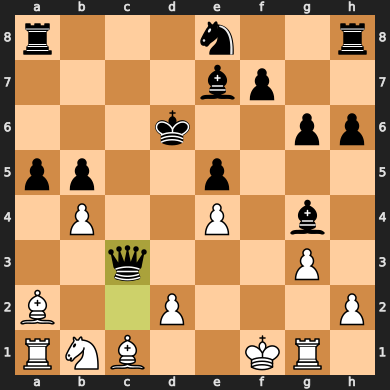


White AI Action: h3, Monte Carlo Tree Search Duration: 14.40s
Black AI Action: h5, Monte Carlo Tree Search Duration: 19.01s
========== Turn 25 ==========


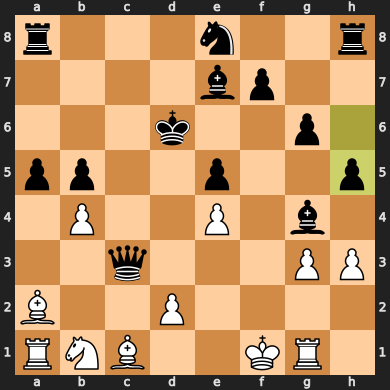


White AI Action: hxg4, Monte Carlo Tree Search Duration: 15.71s
Black AI Action: Qxb4, Monte Carlo Tree Search Duration: 16.16s
========== Turn 26 ==========


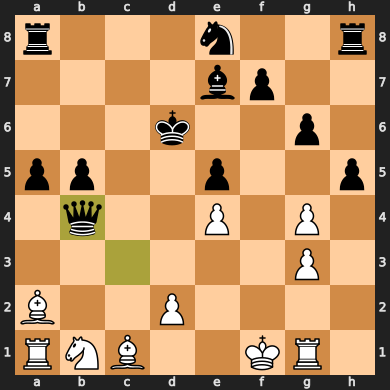


White AI Action: d4, Monte Carlo Tree Search Duration: 14.31s
Black AI Action: Nc7, Monte Carlo Tree Search Duration: 17.81s
========== Turn 27 ==========


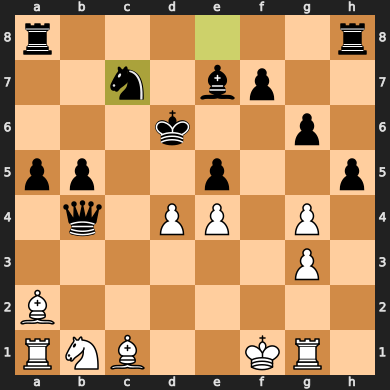


White AI Action: Bh6, Monte Carlo Tree Search Duration: 17.06s
Black AI Action: Na6, Monte Carlo Tree Search Duration: 18.27s
========== Turn 28 ==========


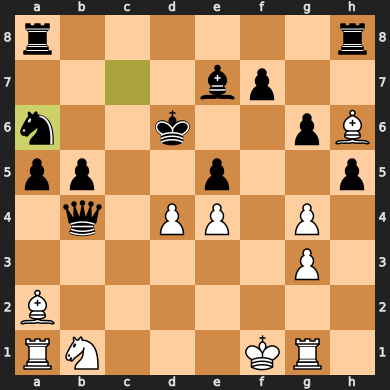


White AI Action: Bc1, Monte Carlo Tree Search Duration: 17.26s
Black AI Action: Bd8, Monte Carlo Tree Search Duration: 15.79s
========== Turn 29 ==========


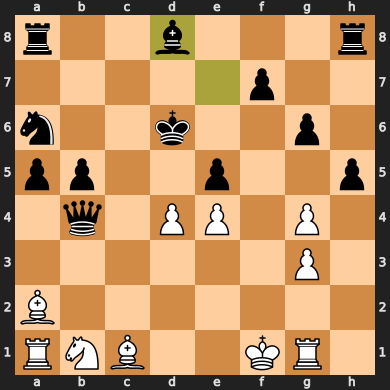


White AI Action: dxe5+, Monte Carlo Tree Search Duration: 18.08s
Black AI Action: Kxe5, Monte Carlo Tree Search Duration: 10.25s
========== Turn 30 ==========


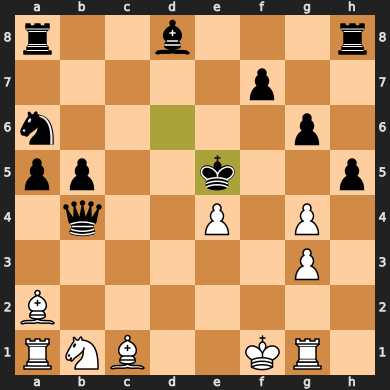


White AI Action: Bd2, Monte Carlo Tree Search Duration: 14.79s
Black AI Action: Rh7, Monte Carlo Tree Search Duration: 14.05s
========== Turn 31 ==========


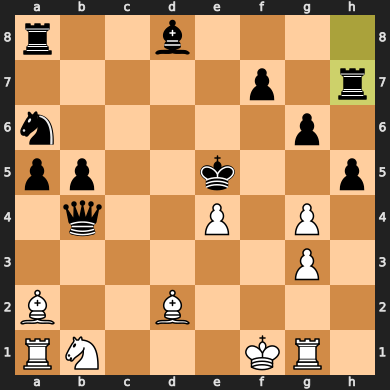


White AI Action: Bb3, Monte Carlo Tree Search Duration: 11.28s
Black AI Action: Bc7, Monte Carlo Tree Search Duration: 13.90s
========== Turn 32 ==========


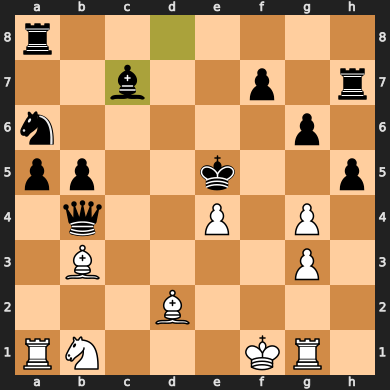


White AI Action: Ba2, Monte Carlo Tree Search Duration: 15.91s
Black AI Action: a4, Monte Carlo Tree Search Duration: 14.20s
========== Turn 33 ==========


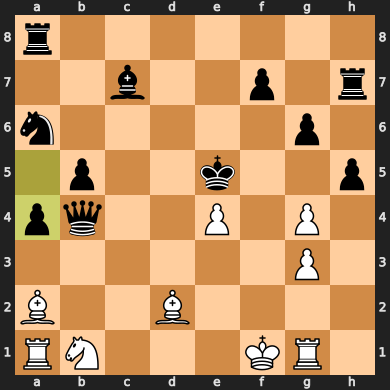


White AI Action: Na3, Monte Carlo Tree Search Duration: 15.99s
Black AI Action: Rhh8, Monte Carlo Tree Search Duration: 15.30s
========== Turn 34 ==========


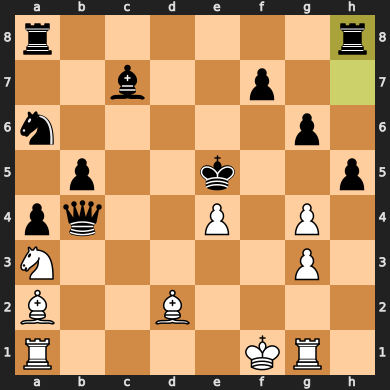


White AI Action: Rb1, Monte Carlo Tree Search Duration: 13.78s
Black AI Action: Rhg8, Monte Carlo Tree Search Duration: 13.58s
========== Turn 35 ==========


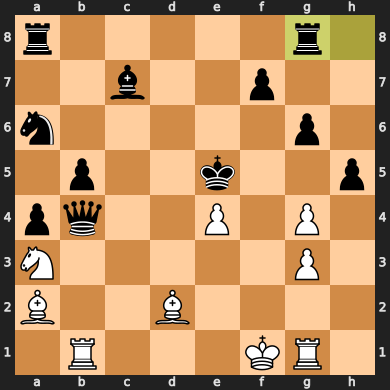


White AI Action: Rg2, Monte Carlo Tree Search Duration: 12.78s
Black AI Action: g5, Monte Carlo Tree Search Duration: 15.23s
========== Turn 36 ==========


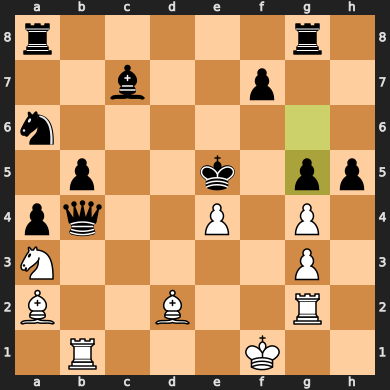


White AI Action: Be3, Monte Carlo Tree Search Duration: 13.54s
Black AI Action: Qxa3, Monte Carlo Tree Search Duration: 12.16s
========== Turn 37 ==========


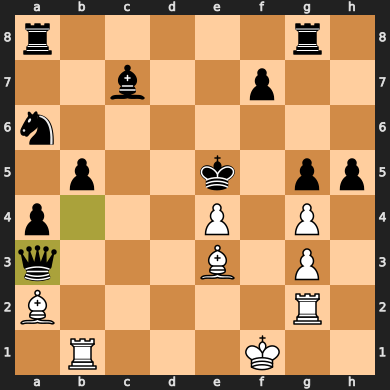


White AI Action: Bc5, Monte Carlo Tree Search Duration: 16.03s
Black AI Action: Rg7, Monte Carlo Tree Search Duration: 13.03s
========== Turn 38 ==========


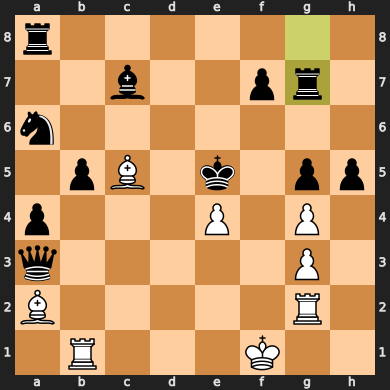


White AI Action: Ba7, Monte Carlo Tree Search Duration: 14.05s
Black AI Action: Qf8, Monte Carlo Tree Search Duration: 11.74s
========== Turn 39 ==========


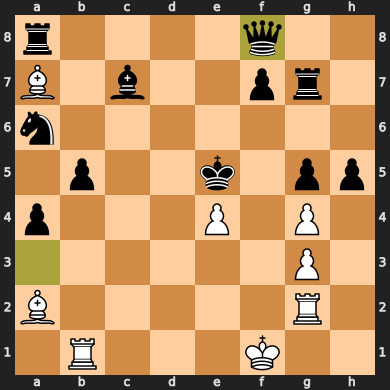


White AI Action: Be3, Monte Carlo Tree Search Duration: 15.56s
Black AI Action: Nb4, Monte Carlo Tree Search Duration: 11.62s
========== Turn 40 ==========


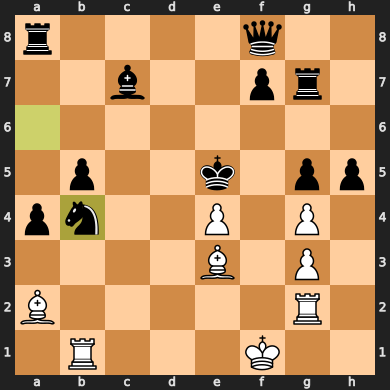


White AI Action: Bc1, Monte Carlo Tree Search Duration: 13.33s
Black AI Action: Ba5, Monte Carlo Tree Search Duration: 14.52s
========== Turn 41 ==========


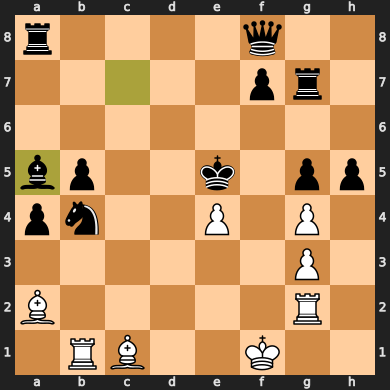


White AI Action: Rb3, Monte Carlo Tree Search Duration: 11.79s
Black AI Action: Qd8, Monte Carlo Tree Search Duration: 13.68s
========== Turn 42 ==========


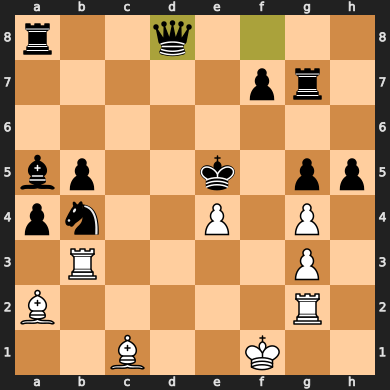


White AI Action: Re2, Monte Carlo Tree Search Duration: 15.95s
Black AI Action: Bc7, Monte Carlo Tree Search Duration: 12.34s
========== Turn 43 ==========


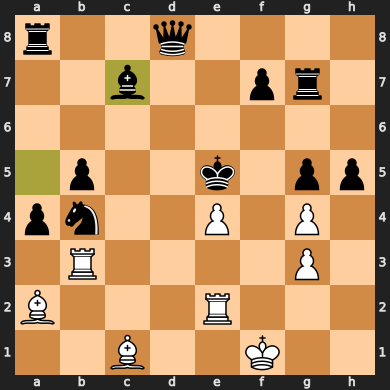


White AI Action: Rb1, Monte Carlo Tree Search Duration: 14.54s
Black AI Action: f6, Monte Carlo Tree Search Duration: 16.42s
========== Turn 44 ==========


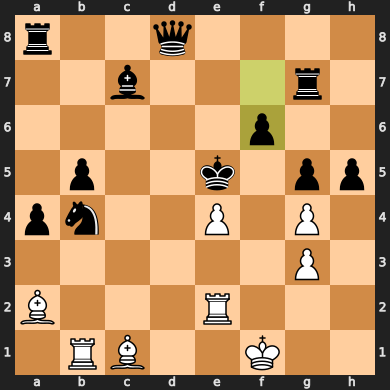


White AI Action: Ba3, Monte Carlo Tree Search Duration: 14.34s
Black AI Action: Nd3, Monte Carlo Tree Search Duration: 14.44s
========== Turn 45 ==========


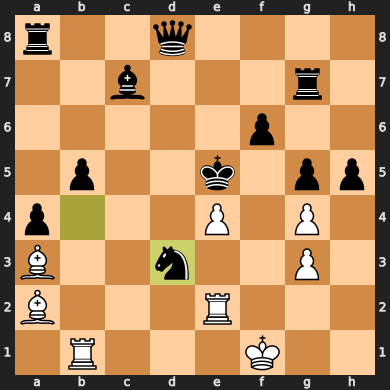


White AI Action: Rh2, Monte Carlo Tree Search Duration: 12.53s
Black AI Action: Qh8, Monte Carlo Tree Search Duration: 11.15s
========== Turn 46 ==========


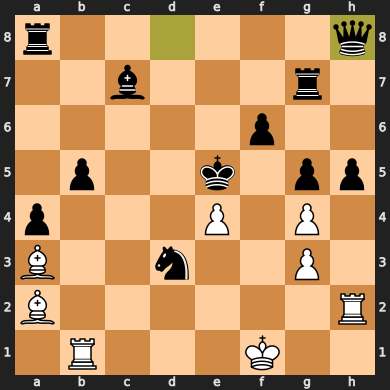


White AI Action: Bd6+, Monte Carlo Tree Search Duration: 13.78s
Black AI Action: Kxe4, Monte Carlo Tree Search Duration: 7.05s
========== Turn 47 ==========


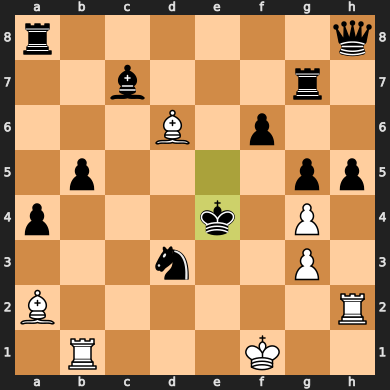


White AI Action: Bf8, Monte Carlo Tree Search Duration: 10.20s
Black AI Action: Bd8, Monte Carlo Tree Search Duration: 12.20s
========== Turn 48 ==========


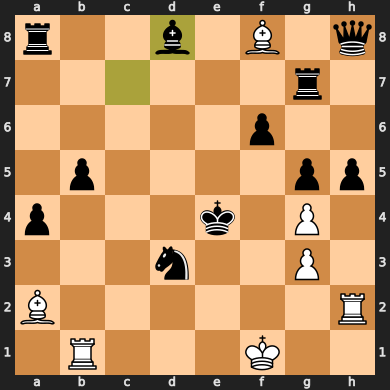


White AI Action: Rxh5, Monte Carlo Tree Search Duration: 10.86s
Black AI Action: Raa7, Monte Carlo Tree Search Duration: 11.97s
========== Turn 49 ==========


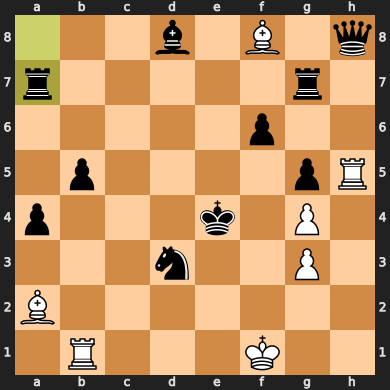


White AI Action: Ba3, Monte Carlo Tree Search Duration: 11.51s
Black AI Action: Rgc7, Monte Carlo Tree Search Duration: 9.52s
========== Turn 50 ==========


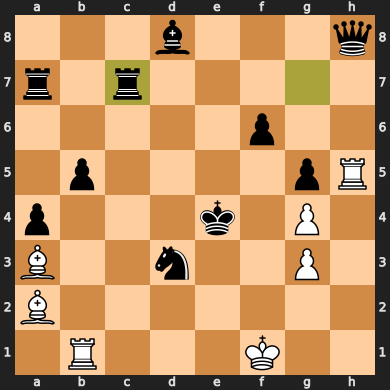


White AI Action: Rb4+, Monte Carlo Tree Search Duration: 8.71s
Black AI Action: Ke3, Monte Carlo Tree Search Duration: 6.05s
========== Turn 51 ==========


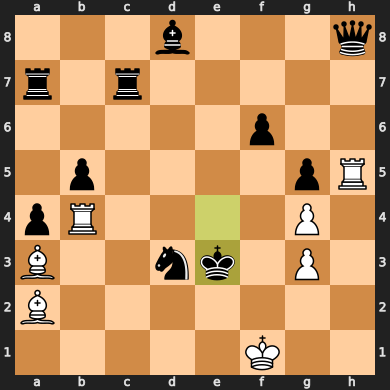


White AI Action: Bc1+, Monte Carlo Tree Search Duration: 8.35s
Black AI Action: Rxc1+, Monte Carlo Tree Search Duration: 4.62s
========== Turn 52 ==========


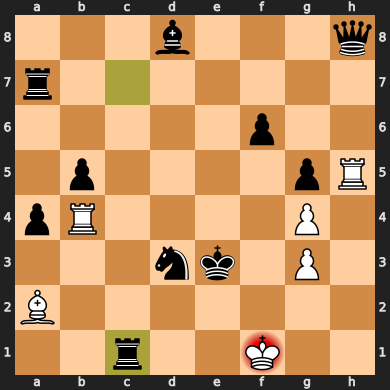


White AI Action: Kg2, Monte Carlo Tree Search Duration: 9.29s
Black AI Action: Rc6, Monte Carlo Tree Search Duration: 10.71s
========== Turn 53 ==========


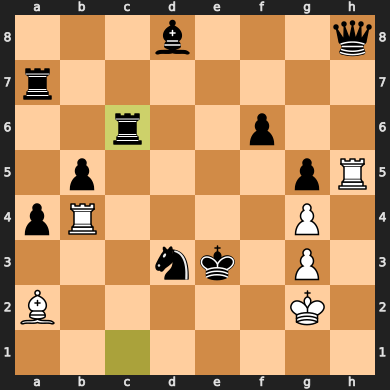


White AI Action: Bf7, Monte Carlo Tree Search Duration: 12.41s
Black AI Action: Rd7, Monte Carlo Tree Search Duration: 12.06s
========== Turn 54 ==========


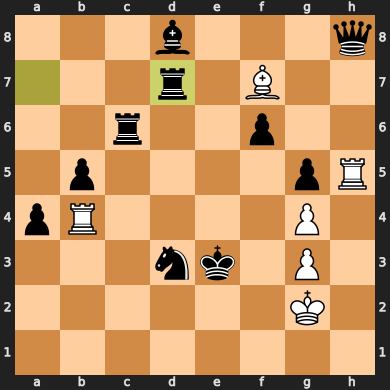


White AI Action: Rh3, Monte Carlo Tree Search Duration: 10.48s
Black AI Action: Ne1+, Monte Carlo Tree Search Duration: 12.36s
========== Turn 55 ==========


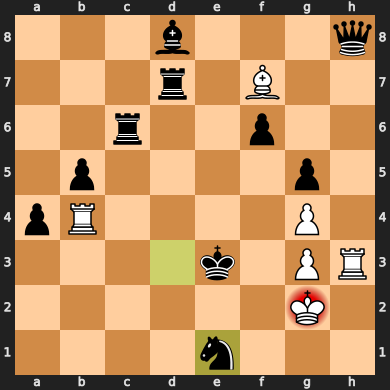


White AI Action: Kh1, Monte Carlo Tree Search Duration: 12.18s
Black AI Action: Rd2, Monte Carlo Tree Search Duration: 9.37s
========== Turn 56 ==========


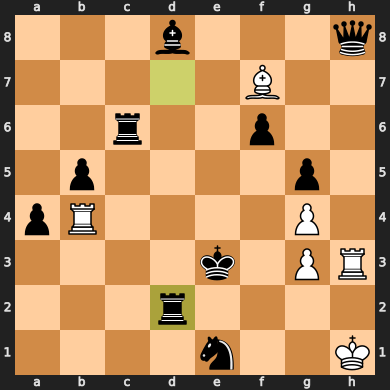


White AI Action: Bg6, Monte Carlo Tree Search Duration: 12.39s
Black AI Action: Nf3, Monte Carlo Tree Search Duration: 12.12s
========== Turn 57 ==========


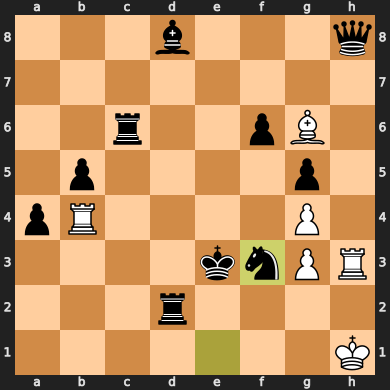


White AI Action: Bf5, Monte Carlo Tree Search Duration: 11.00s
Black AI Action: Re2, Monte Carlo Tree Search Duration: 8.64s
========== Turn 58 ==========


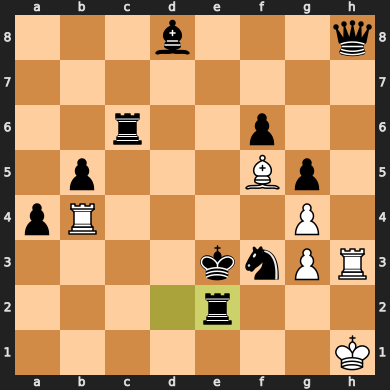


White AI Action: Be4, Monte Carlo Tree Search Duration: 7.36s
Black AI Action: Qxh3#, Monte Carlo Tree Search Duration: 6.23s
========== Turn 59 ==========


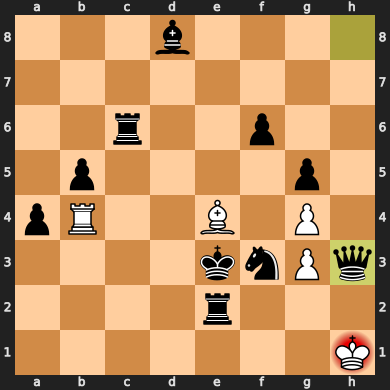

In [18]:
board = chess.Board()
engine = chess.engine.SimpleEngine.popen_uci('stockfish_14.1_linux_x64/stockfish_14.1_linux_x64')

white = 1
moves = 0
pgn = []
total_game_time = 0

game = chess.pgn.Game()

turn = 1
game_round = 1
while not board.is_game_over():
  current_player = 'White' if white == 1 else 'Black'
  start = time.time()

  all_moves = [board.san(i) for i in list(board.legal_moves)]
  root = node()
  root.state = board
  action = monte_carlo_tree_search_prediction(root, board.is_game_over(), white)

  end = time.time()
  duration = end - start
  total_game_time += duration

  print('{} AI Action: {}, Monte Carlo Tree Search Duration: {:.2f}s'.format(current_player, action, duration))
  board.push_san(action)
  pgn.append(action)

  if turn % 2 == 0:
    print('='*10 + ' Turn {} '.format(game_round) + "="*10)
    display(board)
    print('')
    game_round += 1
  
  white ^= 1
  moves += 1
  turn += 1

Total Game Time: 1847.965708732605s


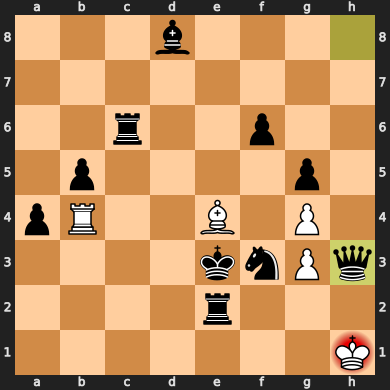

e3 Nc6 f3 h6 a3 Ne5 Nh3 Nf6 e4 Nxf3+ Qxf3 d5 Qf2 e5 Qg1 Kd7 Ba6 Ke8 Bf1 Qd6 Bd3 a5 Qd4 Qxa3 Qb4 Be7 Qd4 g6 Qc4 Qa4 Qxc7 Bxh3 Qd8+ Kxd8 Rg1 Bg4 Bc4 Kc7 g3 Qxc2 b4 Kd6 Kf1 b5 Bxd5 Ne8 Ba2 Qc3 h3 h5 hxg4 Qxb4 d4 Nc7 Bh6 Na6 Bc1 Bd8 dxe5+ Kxe5 Bd2 Rh7 Bb3 Bc7 Ba2 a4 Na3 Rhh8 Rb1 Rhg8 Rg2 g5 Be3 Qxa3 Bc5 Rg7 Ba7 Qf8 Be3 Nb4 Bc1 Ba5 Rb3 Qd8 Re2 Bc7 Rb1 f6 Ba3 Nd3 Rh2 Qh8 Bd6+ Kxe4 Bf8 Bd8 Rxh5 Raa7 Ba3 Rgc7 Rb4+ Ke3 Bc1+ Rxc1+ Kg2 Rc6 Bf7 Rd7 Rh3 Ne1+ Kh1 Rd2 Bg6 Nf3 Bf5 Re2 Be4 Qxh3#

0-1


In [19]:
print('Total Game Time: {}s'.format(total_game_time))
display(board)
print(' '.join(pgn))
print('')
print(board.result())
game.headers['Result'] = board.result()
engine.quit()